# ***1. Import Libraries***

In [1]:
#!pip install cmake
#import cmake
#!pip install numpy==1.20.3
#!pip install pandas==1.1.5
#!pip install catboost==0.26.1

In [2]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
#!pip install country-converter
import country_converter as coco

# Machine Learning
import shap
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from feature_engine.encoding import RareLabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import re

import warnings 
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 1000)

# ***2. Dataset Overview***

In [3]:
df = pd.read_csv("salaries.csv").drop_duplicates()
df.shape

(2801, 11)

In [4]:
df.head()

work_year experience_level employment_type           job_title  salary  \
0       2023               MI              FT  AWS Data Architect  258000   
1       2023               SE              FT      Data Scientist  225000   
2       2023               SE              FT      Data Scientist  156400   
3       2023               SE              FT       Data Engineer  190000   
4       2023               SE              FT       Data Engineer  150000   

  salary_currency  salary_in_usd employee_residence  remote_ratio  \
0             USD         258000                 US           100   
1             USD         225000                 US             0   
2             USD         156400                 US             0   
3             USD         190000                 US           100   
4             USD         150000                 US           100   

  company_location company_size  
0               US            L  
1               US            M  
2               US            M  
3               US            M  
4               US            M

In [5]:
df.dtypes

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

### ***Dataset Explanation:*** 

#### ***1. work_year:*** The year the salary was paid

#### ***2. experience_level:*** The experience level in the job during the year with the following possible values:
    EN = Entry-level / Junior;
    MI = Mid-level / Intermediate;
    SE = Senior-level / Expert;
    EX = Executive-level / Director
    
#### ***3. employment_type:*** The type of employement for the role:
    PT = Part-time;
    FT = Full-time;
    CT = Contract;
    FL = Freelance;

#### ***4. job_title:*** The role worked in during the year.

#### ***5. salary:*** The total gross salary amount paid.

#### ***6. salary_currency:*** The currency of the salary paid as an ISO 4217 currency code.

#### ***7. salary_in_usd:*** The salary in USD (FX rate divided by avg. USD rate for the respective year via fxdata.foorilla.com).

#### ***8. employee_residence:*** Employee's primary country of residence in during the work year as an ISO 3166 country code(Alpha-2 code).

#### ***9. remote_ratio:*** The overall amount of work done remotely, possible values are as follows:
    0 = No remote work (less than 20%);
    50 = Partially remote;
    100 = Fully remote (more than 80%)

#### ***10. company_location:*** The country of the employer's main office or contracting branch as an ISO 3166 country code(Alpha-2 code).

#### ***11. company_size:*** The average number of people that worked for the company during the year:
    S = less than 50 employees (small)
    M = 50 to 250 employees (medium);
    L = more than 250 employees (large)

# ***3. Data Preprocessing***

In [6]:
df.sample(6)#.reset_index(drop=True).style.set_properties(**{'background-color': '#FFF0F5 ','color': 'black','border-color': '#8b8c8c'})

work_year experience_level employment_type                    job_title  \
1752       2023               SE              FT                Data Engineer   
66         2023               EN              FT  Data Integration Specialist   
4005       2021               EN              FT               Data Scientist   
1027       2023               SE              FT                 Data Analyst   
2830       2022               EN              FT                Data Engineer   
425        2023               SE              FT                Data Engineer   

      salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
1752  107000             USD         107000                 US           100   
66     46400             USD          46400                 US           100   
4005   58000             USD          58000                 US            50   
1027  106020             USD         106020                 US             0   
2830   40000             GBP          49253                 GB           100   
425   221484             USD         221484                 US             0   

     company_location company_size  
1752               US            M  
66                 US            M  
4005               US            L  
1027               US            M  
2830               GB            M  
425                US            M

In [7]:
# select label and convert it to kUSD/year
label = 'salary_in_usd'
df[label] = df[label] * 1e-3

# exclude 1% of the smallest and 1% of the highest salaries
P = np.percentile(df[label],[1,99])
df = df[(df[label] > P[0]) & (df[label] < P[1])]

# replace ML Engineer by Machine Learning Engineer
df['job_title'].replace('ML Engineer', 'Machine Learning Engineer', inplace=True)

# rename experience_level
exp_dict = {'EN': 'Entry-level / Junior', 
            'MI': 'Mid-level / Intermediate', 
            'SE': 'Senior-level / Expert', 
            'EX': 'Executive-level / Director'}
df['experience_level'] = df['experience_level'].replace(exp_dict)

# rename employment_type
empl_dict = {'PT': 'Part-time', 'FT': 'Full-time', 'CT': 'Contract', 'FL': 'Freelance'}
df['employment_type'] = df['employment_type'].replace(empl_dict)

# rename remote_ratio
remote_dict = {0: 'No remote work (less than 20%)', 
               50: 'Partially remote', 
               100: 'Fully remote (more than 80%)'}
df['remote_ratio'] = df['remote_ratio'].replace(remote_dict)

# rename company_size
company_dict = {'S': 'Small', 'M': 'Medium', 'L': 'Large'}
df['company_size'] = df['company_size'].replace(company_dict)

# convert work_year to strings
df['work_year'] = df['work_year'].astype(str)

# set up the rare label encoder limiting number of categories to max_n_categories
# with no more than 70 different categories in each column and at least 20 data samples in each category
for col in ['job_title']:
    encoder = RareLabelEncoder(n_categories=1, max_n_categories=30, replace_with='Other', tol=20/df.shape[0])
    df[col] = encoder.fit_transform(df[[col]])
    
# drop unused columns
cols2drop = ['salary', 'salary_currency']
df = df.drop(cols2drop, axis=1)
print(df.shape)

(2743, 9)


### ***ISO code for px.choropleth***

In [8]:
country_names = coco.convert(names=df['company_location'], to="ISO3")
df['company_location'] = country_names
df['company_location'].unique()

employee_residence = coco.convert(names=df['employee_residence'], to="ISO3")
df['employee_residence'] = employee_residence
df['employee_residence'].unique()

array(['USA', 'AUS', 'ARE', 'IND', 'BOL', 'DEU', 'GBR', 'COL', 'EGY',
       'NGA', 'CAN', 'UZB', 'ESP', 'FRA', 'ARG', 'GEO', 'JPN', 'ZAF',
       'ITA', 'HKG', 'PRT', 'NLD', 'CHE', 'CAF', 'FIN', 'UKR', 'IRL',
       'AUT', 'SGP', 'SWE', 'SVN', 'MEX', 'THA', 'GHA', 'HRV', 'POL',
       'BRA', 'KWT', 'VNM', 'CYP', 'ARM', 'BIH', 'KEN', 'GRC', 'LVA',
       'ROU', 'PAK', 'LTU', 'BEL', 'ASM', 'IRN', 'HUN', 'SVK', 'CHN',
       'CRI', 'CHL', 'PRI', 'DNK', 'PHL', 'DOM', 'TUR', 'IDN', 'MYS',
       'EST', 'HND', 'TUN', 'CZE', 'RUS', 'DZA', 'IRQ', 'BGR', 'JEY',
       'SRB', 'NZL', 'MDA', 'LUX', 'MLT'], dtype=object)

In [9]:
df.dtypes

work_year              object
experience_level       object
employment_type        object
job_title              object
salary_in_usd         float64
employee_residence     object
remote_ratio           object
company_location       object
company_size           object
dtype: object

In [10]:
df.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

### ***New Dataframe***

In [11]:
df.sample(10)

work_year          experience_level employment_type  \
3209      2022     Senior-level / Expert       Full-time   
2031      2023     Senior-level / Expert       Full-time   
63        2023     Senior-level / Expert       Full-time   
557       2023     Senior-level / Expert       Full-time   
2439      2022     Senior-level / Expert       Full-time   
3835      2022      Entry-level / Junior        Contract   
4083      2021     Senior-level / Expert       Full-time   
2465      2022     Senior-level / Expert       Full-time   
1717      2023  Mid-level / Intermediate       Full-time   
2673      2022     Senior-level / Expert       Full-time   

                 job_title  salary_in_usd employee_residence  \
3209    Analytics Engineer        122.500                USA   
2031        Data Scientist        105.200                USA   
63           Data Engineer        146.000                USA   
557          Data Engineer        155.000                USA   
2439                 Other        190.000                USA   
3835                 Other         30.469                TUN   
4083         Data Engineer        165.000                USA   
2465          Data Analyst        140.000                USA   
1717         Data Engineer         59.166                ESP   
2673  Data Science Manager        172.200                USA   

                        remote_ratio company_location company_size  
3209    Fully remote (more than 80%)              USA       Medium  
2031  No remote work (less than 20%)              USA       Medium  
63    No remote work (less than 20%)              USA       Medium  
557   No remote work (less than 20%)              USA       Medium  
2439    Fully remote (more than 80%)              USA        Large  
3835    Fully remote (more than 80%)              CZE       Medium  
4083  No remote work (less than 20%)              USA       Medium  
2465    Fully remote (more than 80%)              USA       Medium  
1717    Fully remote (more than 80%)              ESP       Medium  
2673  No remote work (less than 20%)              USA       Medium

# ***4. Exploratory Data Analysis***📊

***Use `set()`method to see how many distinguishing values each categorical attribute has***

In [12]:
print(set(df['work_year'].to_list()))
print(set(df['experience_level'].to_list()))
print(set(df['employment_type'].to_list()))
print(set(df['remote_ratio'].to_list()))
print(set(df['company_size'].to_list()))
print(set(df['employee_residence'].to_list()))
print(set(df['company_location'].to_list()))
print(set(df['job_title'].to_list()))

{'2021', '2022', '2023', '2020'}
{'Executive-level / Director', 'Entry-level / Junior', 'Mid-level / Intermediate', 'Senior-level / Expert'}
{'Part-time', 'Full-time', 'Contract', 'Freelance'}
{'No remote work (less than 20%)', 'Partially remote', 'Fully remote (more than 80%)'}
{'Small', 'Large', 'Medium'}
{'THA', 'HKG', 'CAN', 'FIN', 'IND', 'ESP', 'MEX', 'SVN', 'ARG', 'BGR', 'MDA', 'IDN', 'UZB', 'ASM', 'FRA', 'DEU', 'KEN', 'ITA', 'JEY', 'POL', 'BIH', 'SWE', 'HRV', 'PHL', 'CZE', 'CAF', 'IRL', 'VNM', 'NLD', 'PAK', 'CHN', 'DOM', 'MLT', 'TUN', 'SRB', 'HUN', 'GEO', 'NGA', 'AUT', 'EST', 'ARM', 'JPN', 'GBR', 'DNK', 'CYP', 'DZA', 'EGY', 'LUX', 'CHE', 'BRA', 'LTU', 'RUS', 'GRC', 'TUR', 'NZL', 'USA', 'CRI', 'IRQ', 'CHL', 'BOL', 'KWT', 'ROU', 'LVA', 'SVK', 'UKR', 'IRN', 'HND', 'GHA', 'PRT', 'COL', 'BEL', 'ZAF', 'MYS', 'ARE', 'SGP', 'PRI', 'AUS'}
{'ITA', 'ROU', 'SMR', 'THA', 'LVA', 'SVK', 'UKR', 'HKG', 'CAN', 'FIN', 'POL', 'IND', 'BIH', 'SWE', 'HRV', 'EST', 'AUT', 'ISR', 'PHL', 'ARM', 'ESP', 'IR

***1. How has the average salary of data field jobs fluctuated in recent years around the world?***

In [13]:
salary_timeline = pd.DataFrame(df.groupby("work_year")["salary_in_usd"].mean()).reset_index()

salary_timeline.rename(columns = {'salary_in_usd':'mean_salary_in_usd'}, inplace = True)
salary_timeline["work_year"].replace({2020:"2020",2021:"2021",2022:"2022",2023:"2023"},inplace=True)

salary_timeline

work_year  mean_salary_in_usd
0      2020           85.862588
1      2021           93.267514
2      2022          129.467109
3      2023          146.486611

***Plot it***

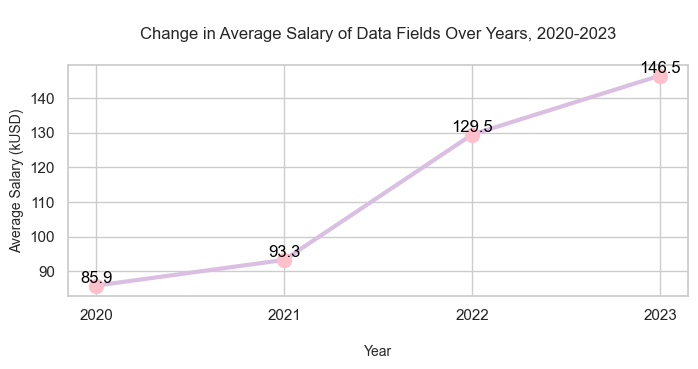

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# Define the 'Beginning of Spring' color palette
palette = ["#bcddf5", "#ccf5bc", "#f2c7e7", "#dabfe3", "#fffbbf"]

# Set the figure size
plt.subplots(figsize=(8, 3))

# Create the line plot
p = sns.lineplot(x=salary_timeline["work_year"], y=salary_timeline["mean_salary_in_usd"], data=salary_timeline, color=palette[3], # Lighter purple color 
                 marker="o",linewidth=3,markersize=10,markerfacecolor='pink',  # Molady marker face color
                 markeredgecolor='pink',markeredgewidth=1)

# Set the plot title and labels
p.axes.set_title("\nChange in Average Salary of Data Fields Over Years, 2020-2023\n", fontsize=12)
p.axes.set_xlabel("\nYear", fontsize=10)
p.axes.set_ylabel("Average Salary (kUSD)", fontsize=10)

# Annotate the y-values on the plot
for x, y in zip(salary_timeline["work_year"], salary_timeline["mean_salary_in_usd"]):
    p.text(x, y, f"{y:.1f}", color='black', ha='center', va='bottom')

# Save the plot as a transparent image
plt.savefig('plot.png', transparent=True)

# Show the plot
plt.show()

***Summary:***

Average salaries in the Data field tend to increase from 2020 to 2023:

Slight increase in the period from 2020 to 2021: from 85.9k - > 93.3k (usd)

Strong increase in the period from 2021 to 2022: from 93.3k -> 129.5k (usd)

Moderate increase in the period from 2022 to 2023: from 129.5k - > 146.5k (usd) 

***2. Where is the ideal land for choosing a workplace for data fields?***

In [15]:
location = df.groupby(['salary_in_usd', 'company_location']).size().reset_index()

average_salary = location.groupby('company_location').mean().reset_index()
average_salary.rename(columns = {'salary_in_usd':'mean_salary_in_usd'}, inplace = True)
average_salary = average_salary[['company_location','mean_salary_in_usd']]

#average_salary.sort_values(by='mean_salary_in_usd', ascending=False)

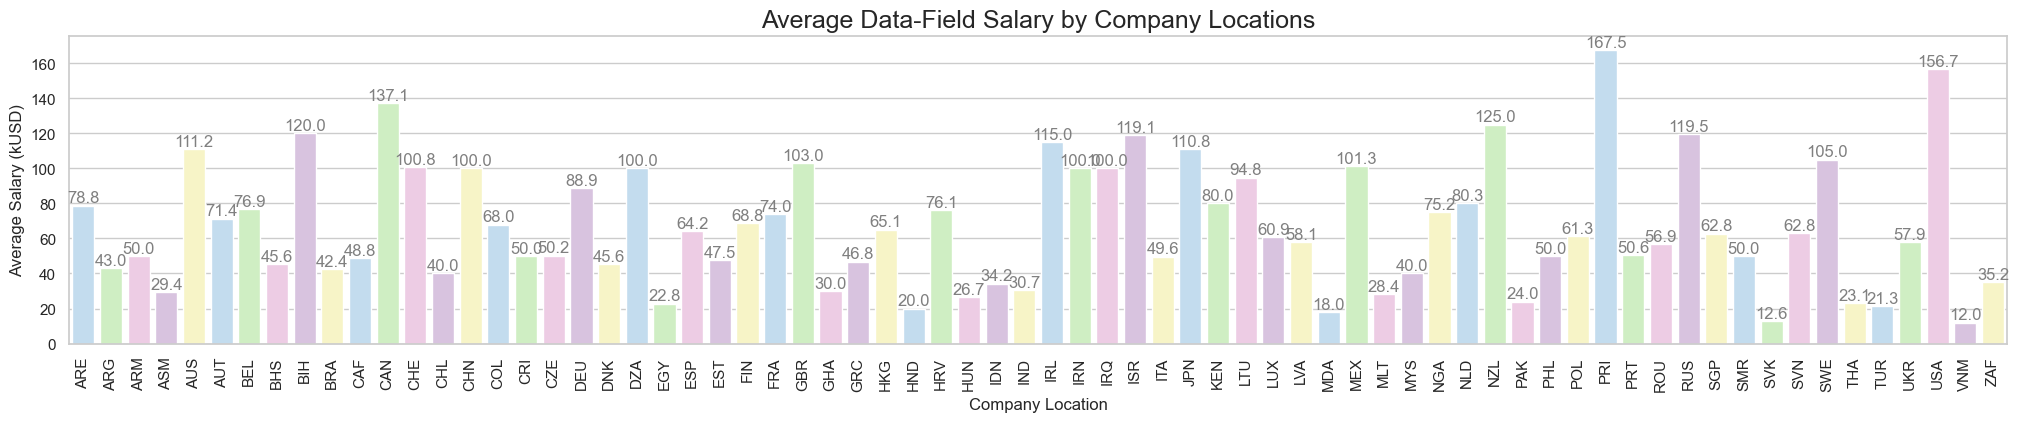

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# Set the figure size
plt.subplots(figsize=(25, 4))

# Create the bar plot
p = sns.barplot(x=average_salary['company_location'], y=average_salary['mean_salary_in_usd'], palette=palette)

# Set the plot title and labels
plt.title("Average Data-Field Salary by Company Locations", fontsize=18)
plt.xlabel("Company Location", fontsize=12)
plt.ylabel("Average Salary (kUSD)", fontsize=12)

# Annotate the y-values on the plot
for index, row in average_salary.iterrows():
    p.text(row.name, row['mean_salary_in_usd'], f"{row['mean_salary_in_usd']:.1f}", color='gray', ha='center', va='bottom')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.show()

In [17]:
fig = px.choropleth(locations=average_salary['company_location'],
                    color=average_salary['mean_salary_in_usd'],
                    color_continuous_scale=px.colors.sequential.RdBu,
                    #color_continuous_scale=palette,
                    template='plotly_dark')
fig.update_layout(font = dict(size=10,family="Courier new"))

fig.update_layout(
    title="Average Data-Field Salary by Company Locations", title_x=0.5,
    font=dict(
        family="Rubik",
        size=18
    )
)

fig.show()

***Summary:***

Based on the visual image we can see, the countries with very high average salary are: USA (156.65k), Canada (137.09k), New Zealand(125k), Russia (119.5k), Australia (111.24k), Japan (110.82k).

These are all the leading developed countries in the world in all fields and these countries are willing to pay a very good salary for human resources in the field of Data. It proves that Data is an important career field in the development of the country and workers can consider choosing these countries to develop their career and have a good income.

***3. Percentage of working for foreign companies of each job (an employee is considered to work for a foreign company if there is another employee_residence than company_location)***

In [29]:
#Selecting relevant columns from the dataframe
df3 = df[['job_title', 'employee_residence', 'company_location']]

#Creating a list of job titles where the employee residence and company location do not match
l0 = list(df3['job_title'].values)
l1 = list(df3['employee_residence'].values)
l2 = list(df3['company_location'].values)
job_titles = [l0[i] for i in range(len(l0)) if l1[i] != l2[i]]

#Converting the list into set, finding the unique job titles and converting them into a dataframe
set_job_titles = list(set(job_titles))
job_titles_df = pd.DataFrame({'data': job_titles})

#Creating a list of percentages for each unique job title and converting it into a series
percents = []
for i in set_job_titles:
    percents.append(((job_titles_df['data'].value_counts()[i] / len(job_titles_df)) * 100).round(1))

job_titles_series = pd.Series(index=set_job_titles, data=percents)
job_titles_series = job_titles_series.sort_values(ascending=False)
job_titles_series

Other                         50.0
Data Scientist                20.4
Data Analyst                   9.2
Data Engineer                  8.2
Machine Learning Engineer      3.1
Data Science Manager           3.1
Machine Learning Scientist     2.0
Research Scientist             2.0
Analytics Engineer             1.0
Data Science Consultant        1.0
dtype: float64

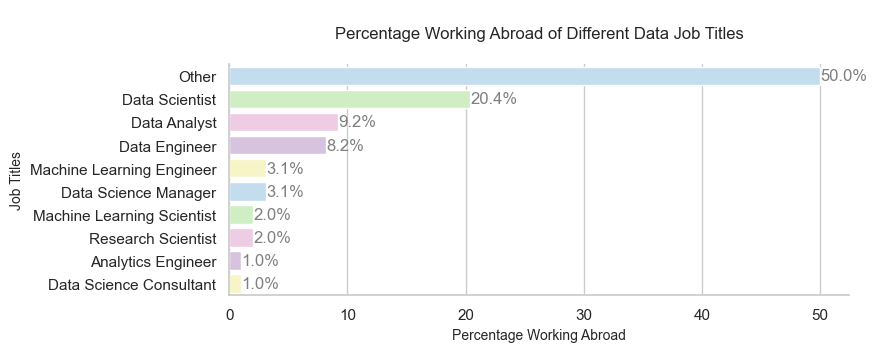

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# Set the figure size
plt.subplots(figsize=(8, 3))

# Transpose the data
job_titles_series = job_titles_series.transpose()

# Create the bar plot
p = sns.barplot(job_titles_series.values, job_titles_series.index, palette=palette)

# Set the plot title and labels
p.axes.set_title("\nPercentage Working Abroad of Different Data Job Titles\n", fontsize=12)
p.axes.set_xlabel("Percentage Working Abroad", fontsize=10)
p.axes.set_ylabel("Job Titles", fontsize=10)
p.axes.set_xticklabels(p.get_xticklabels(), rotation=0)  # Rotate x-axis tick labels

# Annotate the y-values on the plot
for i, value in enumerate(job_titles_series.values):
    p.text(value, i, f"{value:.1f}%", color='gray', ha='left', va='center')

# Remove spines
sns.despine(left=False, bottom=False)

# Show the plot
plt.show()

***Summary:***

The familiar roles that always account for the highest percentage are: Data Scientist, Data Analyst, Data Engineer, Machine Learning Engineer. Understandably, with the strong development of data science and computer science today, the jobs mentioned above are jobs that require very high human resources in today's era, so they are not just In the domestic environment that relies on foreign direct investment of countries is increasingly promoted, the percentage of working for foreign companies is increasing.

***4. Average salary between types of employees (employment_type) of different sizes of companies (company_size)?***

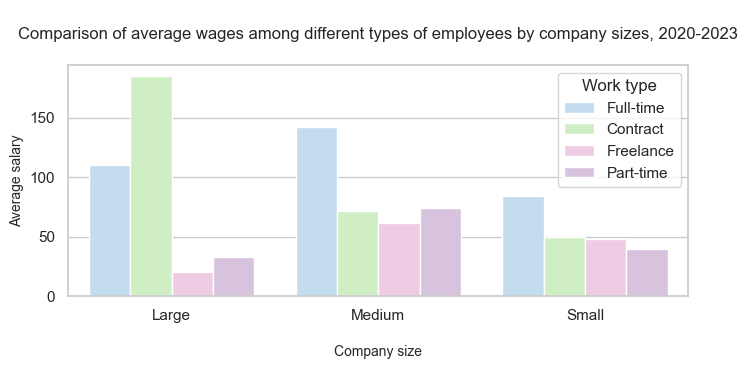

In [43]:
plt.subplots(figsize=(8,3))
p = sns.barplot(data=df, x='company_size', y='salary_in_usd', hue='employment_type', palette=palette,ci=None)
p.set_title('\nComparison of average wages among different types of employees by company sizes, 2020-2023\n', fontsize=12)
p.set_xlabel('\nCompany size', fontsize=10)
p.set_ylabel('Average salary', fontsize=10)
plt.legend(title='Work type')
plt.show()

***Year 2020***

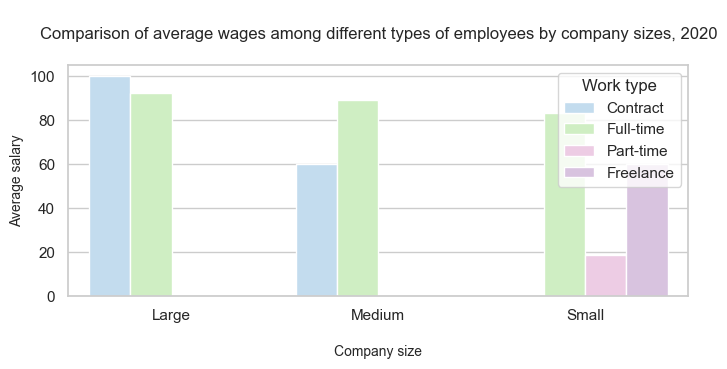

In [44]:
plt.subplots(figsize=(8, 3))
df_2020 = df[df['work_year'] == '2020']  # Filter the DataFrame for year 2021

order = ["Large", "Medium", "Small"]
p = sns.barplot(data=df_2020, x='company_size', y='salary_in_usd', hue='employment_type', palette=palette,order=order, ci=None)
p.set_title('\nComparison of average wages among different types of employees by company sizes, 2020\n', fontsize=12)
p.set_xlabel('\nCompany size', fontsize=10)
p.set_ylabel('Average salary', fontsize=10)
plt.legend(title='Work type')
plt.show()

***Year 2021***

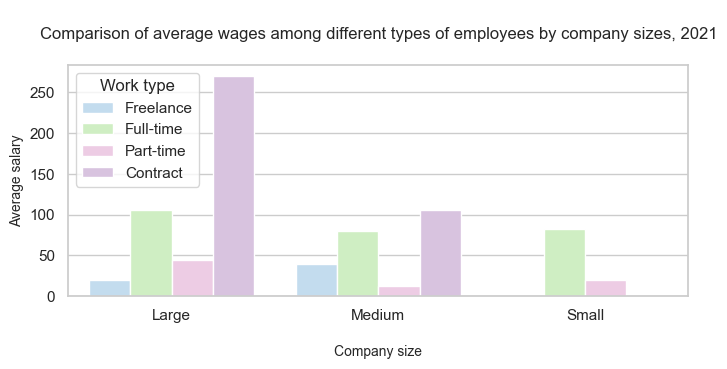

In [42]:
plt.subplots(figsize=(8, 3))
df_2021 = df[df['work_year'] == '2021']  # Filter the DataFrame for year 2021

order = ["Large", "Medium", "Small"]
p = sns.barplot(data=df_2021, x='company_size', y='salary_in_usd', hue='employment_type', palette=palette,order=order, ci=None)
p.set_title('\nComparison of average wages among different types of employees by company sizes, 2021\n', fontsize=12)
p.set_xlabel('\nCompany size', fontsize=10)
p.set_ylabel('Average salary', fontsize=10)
plt.legend(title='Work type')
plt.show()

***Year 2022***

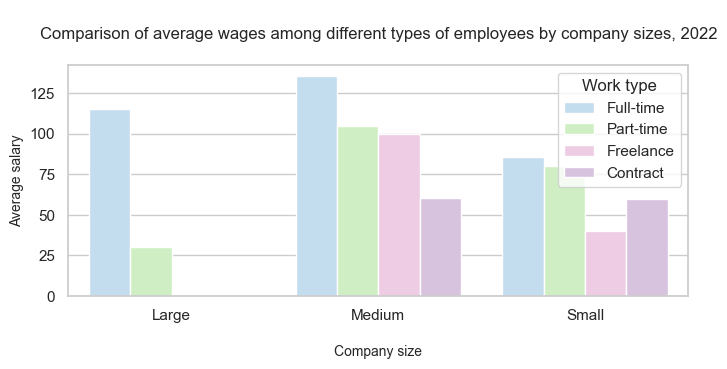

In [40]:
plt.subplots(figsize=(8, 3))
df_2022 = df[df['work_year'] == '2022']  # Filter the DataFrame for year 2022

order = ["Large", "Medium", "Small"]
p = sns.barplot(data=df_2022, x='company_size', y='salary_in_usd', hue='employment_type', palette=palette, order=order, ci=None)
p.set_title('\nComparison of average wages among different types of employees by company sizes, 2022\n', fontsize=12)
p.set_xlabel('\nCompany size', fontsize=10)
p.set_ylabel('Average salary', fontsize=10)
plt.legend(title='Work type')
plt.show()

***Year 2023***

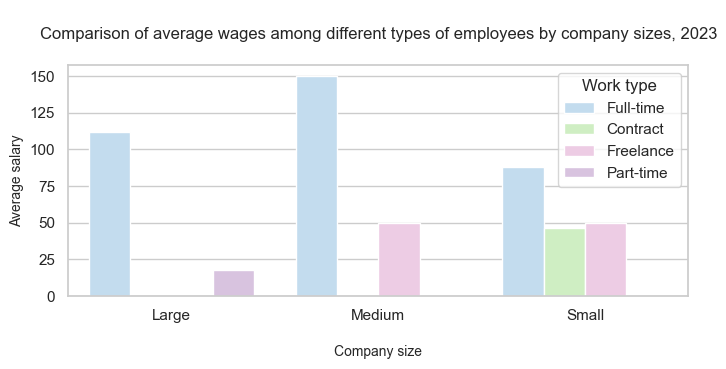

In [36]:
plt.subplots(figsize=(8, 3))
df_2023 = df[df['work_year'] == '2023']  # Filter the DataFrame for year 2023

p = sns.barplot(data=df_2023, x='company_size', y='salary_in_usd', hue='employment_type', palette=palette, ci=None)
p.set_title('\nComparison of average wages among different types of employees by company sizes, 2023\n', fontsize=12)
p.set_xlabel('\nCompany size', fontsize=10)
p.set_ylabel('Average salary', fontsize=10)
plt.legend(title='Work type')
plt.show()

***Summary:***

***Horizontally,***

- The type of ***contract workers*** in small companies has the highest average salary and over 400,000 USD. This is also the highest type of large company but less than 200,000 USD.
- The type of ***full-time*** employee is most suitable for medium-sized companies because this type is higher in large and small scale, as well as highest in medium size.
- ***Part-time*** and ***freelance*** type with average salary paid roughly in small and medium scale; medium company size is slightly better than small size for paying for both types.

***Vertically,***
- ***Contractors***'employee number deduct siginificantly. It happened almost only in year 2021 and for large size companies. It indicate the high needs for human resources in data fields at that time, and people are willing to accept the position even they may not receive the same wages or privilleges as full-time workers.
- ***Freelancing*** is becoming a trend under the current job market situation. 
- ***Full-time*** is always the No.1 preferred employment type for every size of companies, except year 2021, while everybody was wfh, so ***part-time*** becomes dominant.
- ***Part-time*** is no longer preferred, especially in medium and small size companies. 

***5. Get a general view of the change in salary of experience levels over the years. Evaluate the influence of work experience on salary.***

In [48]:
year_salary=df.groupby(["work_year","experience_level"])["salary_in_usd"].mean()
year_salary=year_salary.reset_index()
year_salary.sample(5)

work_year            experience_level  salary_in_usd
8       2022        Entry-level / Junior      71.456933
10      2022    Mid-level / Intermediate      99.598274
9       2022  Executive-level / Director     180.149263
13      2023  Executive-level / Director     195.157540
5       2021  Executive-level / Director     160.586667

In [109]:
import plotly.graph_objects as go
fig = go.Figure()

for exp_level, color in zip(year_salary['experience_level'].unique(), palette):
    data = year_salary[year_salary['experience_level'] == exp_level]
    fig.add_trace(go.Scatter(x=data['work_year'],y=data['salary_in_usd'],
        mode='lines+markers',name=exp_level,line=dict(color=color),marker=dict(color=color)))
    
fig.update_layout(
    height=300,
    width=800,
    title='Average salary of experience levels by year, 2020-2023',
    yaxis_title="Salary (kUSD)",
    xaxis_title="Years",
    xaxis=dict(tickmode='array', tickvals=[2020, 2021, 2022, 2023]),
    plot_bgcolor='white')
fig.show()

***6. Where are the top 5 roles with the highest average salary?***

In [97]:
role_salary = df.groupby('job_title',as_index=False)['salary_in_usd'].mean()
role_salary = role_salary.sort_values(by='salary_in_usd',ascending=False)
role_salary.sample(10)

job_title  salary_in_usd
12           Research Engineer     169.089156
6      Data Science Consultant      95.058458
3               Data Architect     164.612318
7         Data Science Manager     181.951278
1            Applied Scientist     180.079394
2                 Data Analyst     105.920097
10  Machine Learning Scientist     172.658774
9    Machine Learning Engineer     152.609409
4                Data Engineer     139.903324
5                 Data Manager     112.998720

In [108]:
import plotly.graph_objects as go

fig = go.Figure()

for exp_level, color in zip(role_salary['job_title'].unique(), palette):
    data = role_salary[role_salary['job_title'] == exp_level]
    fig.add_trace(go.Bar(x=data['job_title'],y=data['salary_in_usd'],marker=dict(color=color),name=exp_level))

fig.update_layout(
    height=400,width=800,xaxis_title='Job Title',yaxis_title='Salary (kUSD)',title='Top 5 Highest Paying Roles in Data Fields')

fig.show()

# ***5. Machine Learning***

### ***Randomly split data between training and test samples and modelled with the CatBoostRegressor model that explicitly takes into account categorical features.***

In [110]:
# initialize data
y = df[label].values.reshape(-1,)
X = df.drop([label], axis=1)
cat_cols = df.select_dtypes(include=['object']).columns
cat_cols_idx = [list(X.columns).index(c) for c in cat_cols]
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.5, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1371, 8), (1372, 8), (1371,), (1372,))

In [114]:
# initialize Pool
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=cat_cols_idx)
test_pool = Pool(X_test,
                 y_test,
                 cat_features=cat_cols_idx)
# specify the training parameters 
model = CatBoostRegressor(iterations=800, 
                          depth=5,
                          verbose=0,
                          learning_rate=0.01, 
                          loss_function='RMSE')
#train the model
model.fit(train_pool)
# make the prediction using the resulting model
y_train_pred = model.predict(train_pool)
y_test_pred = model.predict(test_pool)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"RMSE score for train {round(rmse_train,1)} kUSD/year, and for test {round(rmse_test,1)} kUSD/year")

RMSE score for train 43.6 kUSD/year, and for test 46.8 kUSD/year


In [115]:
# Baseline scores (assuming the same prediction for all data samples)
rmse_bs_train = mean_squared_error(y_train, [np.mean(y_train)]*len(y_train), squared=False)
rmse_bs_test = mean_squared_error(y_test, [np.mean(y_train)]*len(y_test), squared=False)
print(f"RMSE baseline score for train {round(rmse_bs_train,1)} kUSD/year, and for test {round(rmse_bs_test,1)} kUSD/year")

RMSE baseline score for train 61.9 kUSD/year, and for test 63.2 kUSD/year


# ***6. Explanations with SHAP Values***

***Explain the model's predictions for the test data set using SHAP library***

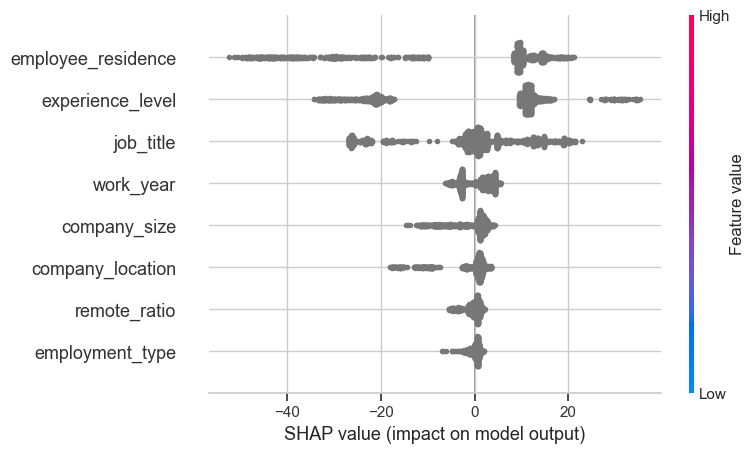

In [129]:
shap.initjs()
ex = shap.TreeExplainer(model)
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [117]:
expected_values = ex.expected_value
print(f"Average predicted salary is {round(expected_values,1)} kUSD/year")
print(f"Average actual salary is {round(np.mean(y_test),1)} kUSD/year")

Average predicted salary is 134.3 kUSD/year
Average actual salary is 133.4 kUSD/year



work_year



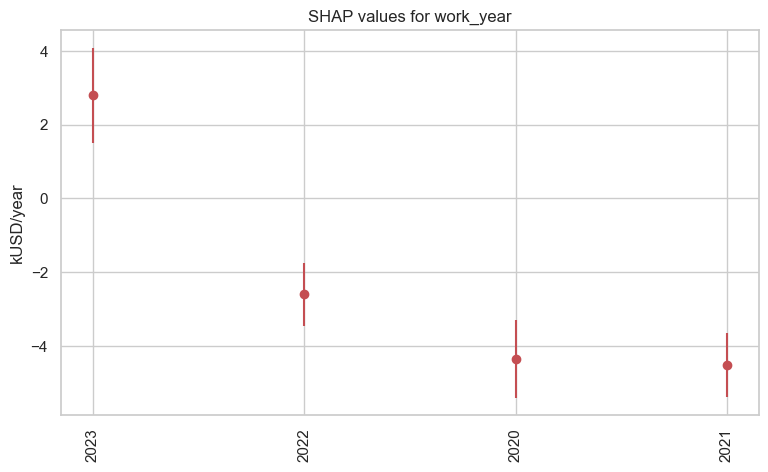

         gain  gain_std  count
col                           
2023  2.79823   1.29027    676
2022 -2.60493   0.84433    535
2020 -4.35268   1.05065     38
2021 -4.52780   0.87321    123

experience_level



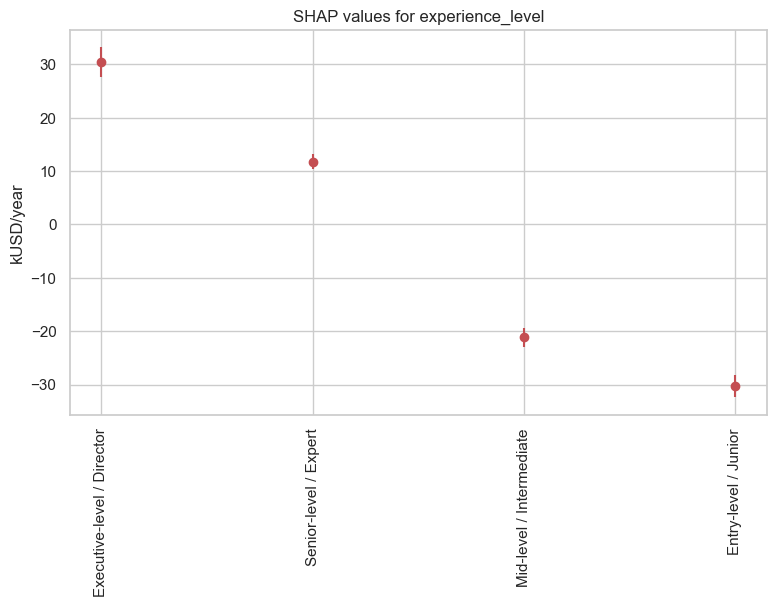

                                gain  gain_std  count
col                                                  
Executive-level / Director  30.38604   2.79194     50
Senior-level / Expert       11.75304   1.40658    835
Mid-level / Intermediate   -21.17923   1.85398    356
Entry-level / Junior       -30.30635   2.11563    131

employment_type



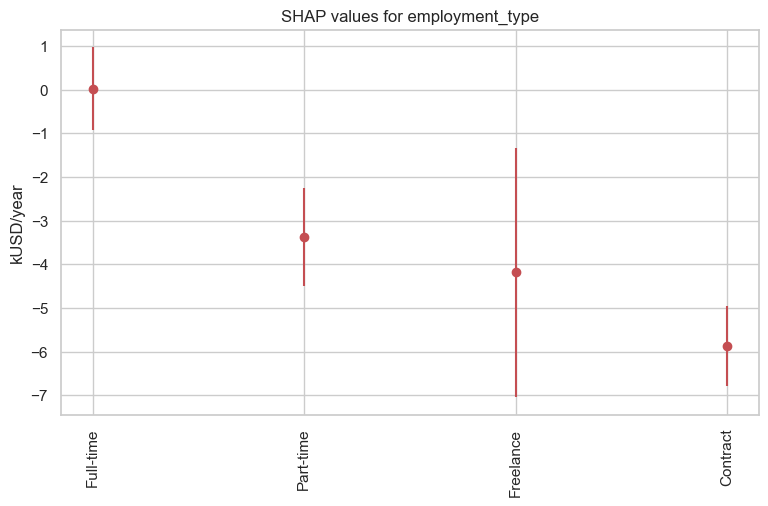

              gain  gain_std  count
col                                
Full-time  0.01956   0.95160   1358
Part-time -3.36967   1.12553      8
Freelance -4.18840   2.86079      3
Contract  -5.86733   0.92063      3

job_title



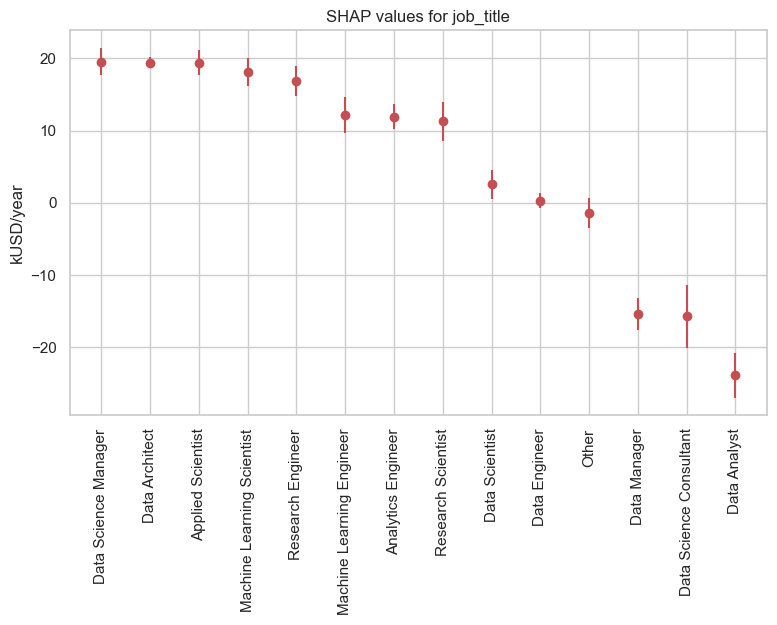

                                gain  gain_std  count
col                                                  
Data Science Manager        19.55338   1.91342     22
Data Architect              19.41000   0.82472     34
Applied Scientist           19.36272   1.74147     13
Machine Learning Scientist  18.09464   1.97507     18
Research Engineer           16.83180   2.09199     21
Machine Learning Engineer   12.21419   2.49231    131
Analytics Engineer          11.92552   1.70762     52
Research Scientist          11.24703   2.74820     38
Data Scientist               2.53355   2.05467    290
Data Engineer                0.28786   0.99607    319
Other                       -1.45894   2.05777    211
Data Manager               -15.45260   2.20488     13
Data Science Consultant    -15.73180   4.38518     10
Data Analyst               -23.89352   3.09516    200

employee_residence



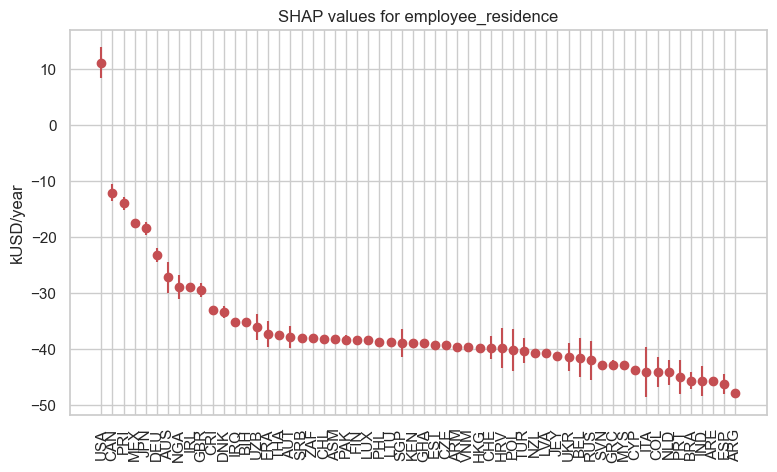

         gain  gain_std  count
col                           
USA  11.20967   2.73507    985
CAN -12.05172   1.60525     51
PRI -13.98557   1.16790      2
MEX -17.54730   0.83647      5
JPN -18.41608   1.15036      6
DEU -23.28289   1.23868     29
AUS -27.20576   2.76500      8
NGA -28.88696   2.13833      3
IRL -28.95846   0.13100      2
GBR -29.54790   1.23091     89
CRI -32.99947       NaN      1
DNK -33.48416   1.05500      2
IRQ -35.19289       NaN      1
BIH -35.29941       NaN      1
UZB -36.09764   2.36664      2
FRA -37.37983   2.29419     17
THA -37.53045   0.46824      2
AUT -37.87420   1.99784      5
SRB -38.13102       NaN      1
ZAF -38.15114       NaN      1
CHL -38.18346       NaN      1
ASM -38.21834       NaN      1
PAK -38.42150   0.91364      5
FIN -38.48611       NaN      1
LUX -38.50545       NaN      1
PHL -38.72345       NaN      1
LTU -38.82416       NaN      1
SGP -38.91361   2.50043      3
KEN -38.93203       NaN      1
GHA -38.98139       NaN      1
EST -39.

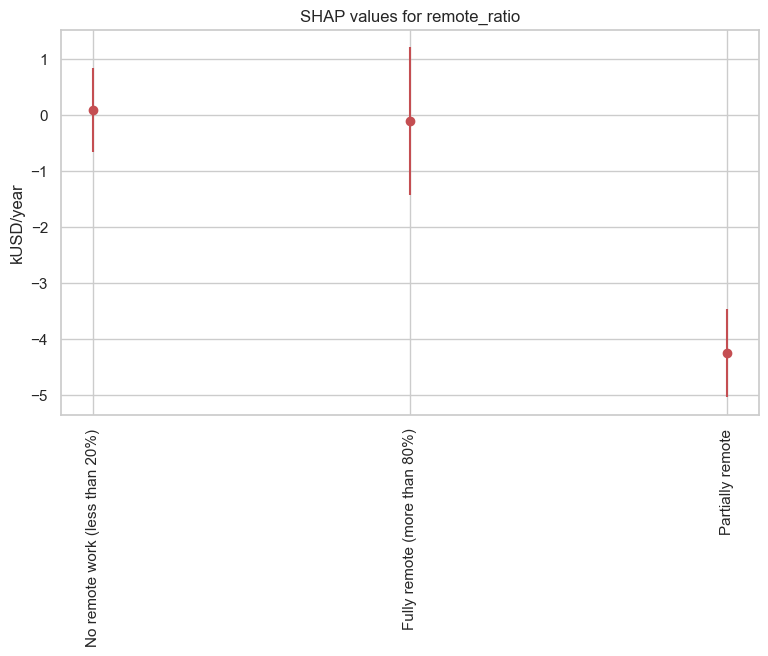

                                   gain  gain_std  count
col                                                     
No remote work (less than 20%)  0.09031   0.75178    640
Fully remote (more than 80%)   -0.11295   1.31584    625
Partially remote               -4.24790   0.78902    107

company_location



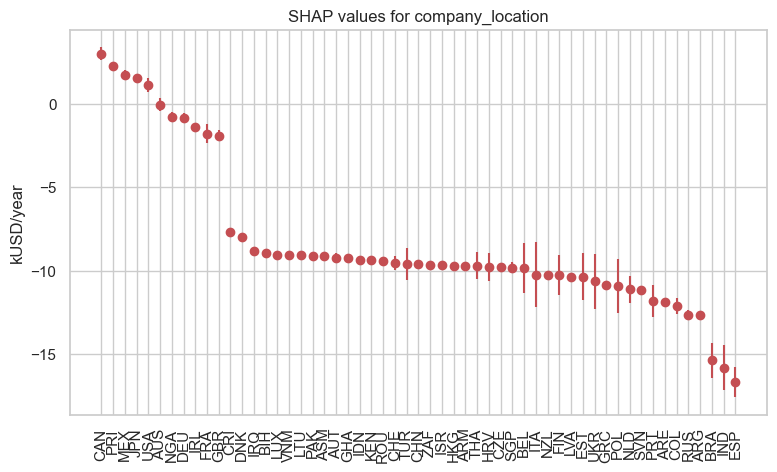

         gain  gain_std  count
col                           
CAN   2.99344   0.38123     55
PRI   2.26410   0.07177      2
MEX   1.70462   0.29669      5
JPN   1.56199   0.05352      6
USA   1.09216   0.41785   1004
AUS  -0.05650   0.36831      9
NGA  -0.77407   0.28480      2
DEU  -0.87736   0.30731     31
IRL  -1.42325   0.00310      2
FRA  -1.79474   0.56783     14
GBR  -1.91980   0.33252     92
CRI  -7.66405       NaN      1
DNK  -8.00155   0.23782      2
IRQ  -8.82484       NaN      1
BIH  -8.95538       NaN      1
LUX  -9.04181   0.03039      2
VNM  -9.06075       NaN      1
LTU  -9.07502       NaN      1
PAK  -9.08911   0.17930      2
ASM  -9.12497   0.17885      2
AUT  -9.21450   0.30444      5
GHA  -9.25404       NaN      1
IDN  -9.36589       NaN      1
KEN  -9.36786       NaN      1
ROU  -9.39526       NaN      1
CHE  -9.53578   0.40255      4
TUR  -9.58814   0.97026      3
CHN  -9.60040       NaN      1
ZAF  -9.64160       NaN      1
ISR  -9.65896       NaN      1
HKG  -9.

            gain  gain_std  count
col                              
Medium   1.40235   1.02832   1101
Large   -5.87556   1.97087    201
Small  -10.30487   1.69227     70


In [121]:
def show_shap(col, shap_values=shap_values):
    df_infl = X_test.copy()
    df_infl['shap_'] = shap_values[:,df_infl.columns.tolist().index(col)]
    gain = round(df_infl.groupby(col).mean()['shap_'],5)
    gain_std = round(df_infl.groupby(col).std()['shap_'],5)
    cnt = df_infl.groupby(col).count()['shap_']
    dd_dict = {'col': list(gain.index), 'gain': list(gain.values), 'gain_std': list(gain_std.values), 'count': cnt}
    df_res = pd.DataFrame.from_dict(dd_dict).sort_values('gain', ascending=False).set_index('col')
    plt.figure(figsize=(9,5))
    plt.errorbar(df_res.index, df_res['gain'], yerr=df_res['gain_std'], fmt="o", color="r")
    plt.title(f'SHAP values for {col}')
    plt.ylabel('kUSD/year')
    plt.tick_params(axis="x", rotation=90)
    plt.show();
    print(df_res)
    return

for col in X_test.columns:
    print()
    print(col)
    print()
    show_shap(col, shap_values)

***Summary:***

The most essential features that determine the salary of Data professionals are the employee residence, experience level, and job title.

For the work year, not surprisingly, we see that the highest gross salaries are associated with the 2023 year: In other words, assuming other variables to be the same, the average gross salary (worldwide) increased between 2022 and 2023 by about 5.4 kUSD/year, or by about 4.5%.

Regarding experience levels, not surprisingly, the highest gross salaries are associated with Executive-level or Director roles. 

About employment types, the highest gross salaries are associated with full-time employment.

About job titles, remarkably, the highest gross salaries are associated with Data Science Managers, followed by Machine Learning Scientists, Applied Scientists, Research Engineers, Research Scientists, and Data Architects:

Regarding employee residence countries, we see that the highest gross salaries are associated with the United States, followed by Canada and Germany.

About the remote work ratio, remarkably, the highest gross salaries are associated with either no remote or fully remote jobs:

Regarding company location countries, we see that the highest gross salaries are also associated with the United States, followed by Canada and Germany.

Finally, about company sizes, we see that the highest gross salaries are associated with medium-sized companies (50 to 250 employees).

## ***SHAP value visualization for the first observation***

***Ref: Introduction to SHAP with Python https://towardsdatascience.com/introduction-to-shap-with-python-d27edc23c454***

In [134]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

***1.Waterfall***

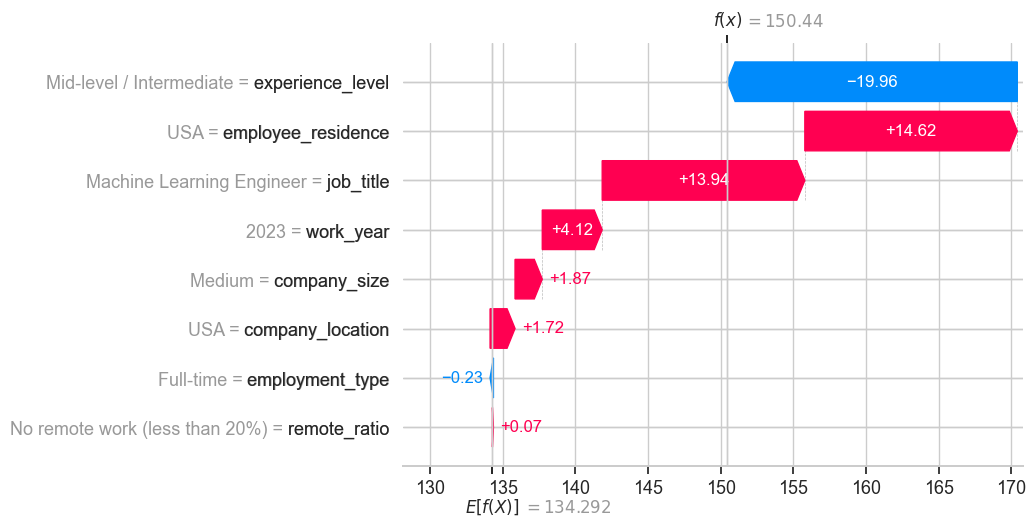

In [140]:
shap.plots.waterfall(shap_values[0])

***2. Force Plot***

In [142]:
shap.plots.force(shap_values[0])

***3.Stacked Force plot***

In [143]:
shap.plots.force(shap_values[0:1000])

***4.Mean SHAP***

In [144]:
shap.plots.bar(shap_values)

***5. Beeswarm***

In [145]:
shap.plots.beeswarm(shap_values)